In [1]:
# !pip install --upgrade pandas numpy scikit-learn matplotlib seaborn six tensorflow

In [2]:
# !pip install --upgrade machine-learning-datasets
# !pip install --upgrade rulefit interpret skope-rules
# !pip install --no-deps git+https://github.com/maxfrenzel/CompressionVAE.git

In [3]:
import math
import machine_learning_datasets as mldatasets
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics, linear_model, tree, naive_bayes, neighbors, ensemble,\
                    neural_network, svm, decomposition, manifold
from rulefit import RuleFit
import statsmodels.api as sm
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.perf import ROC
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import sys
# Next two lines of code only needed while CVAE 
# remains incompatible to Tensorflow 2.2+
import tensorflow.compat.v1 as tf
sys.modules['tensorflow'] = tf
from cvae import cvae
# Next two lines of code only needed while SkopedRules
# remains incompatible to Sklearn 0.23.0+
import six
sys.modules['sklearn.externals.six'] = six
from skrules import SkopeRules

2023-12-19 23:29:46.581419: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 23:29:46.581467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 23:29:46.589876: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-19 23:29:46.611671: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-19 23:29:47.722688: W tensorflow/compiler/tf2

In [5]:
aad18_df = mldatasets.load("aa-domestic-delays-2018")
aad18_df.info()

https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/raw/master/datasets/aa-domestic-delays-2018.csv.zip downloaded to /home/leonardo_leads/Documents/SchoolDocs/Schmidl-DS-Practice/vdsmlStarterLib/interpretableMLWpython/chapter3/data/aa-domestic-delays-2018.csv.zip
/home/leonardo_leads/Documents/SchoolDocs/Schmidl-DS-Practice/vdsmlStarterLib/interpretableMLWpython/chapter3/data/aa-domestic-delays-2018.csv.zip uncompressed to /home/leonardo_leads/Documents/SchoolDocs/Schmidl-DS-Practice/vdsmlStarterLib/interpretableMLWpython/chapter3/data/aa-domestic-delays-2018.csv
1 dataset files found in /home/leonardo_leads/Documents/SchoolDocs/Schmidl-DS-Practice/vdsmlStarterLib/interpretableMLWpython/chapter3/data/aa-domestic-delays-2018.csv folder
parsing /home/leonardo_leads/Documents/SchoolDocs/Schmidl-DS-Practice/vdsmlStarterLib/interpretableMLWpython/chapter3/data/aa-domestic-delays-2018.csv/aa-domestic-delays-2018.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex:

In [6]:
aad18_df['PLANNED_DEP_DATETIME'] = pd.to_datetime(aad18_df['PLANNED_DEP_DATETIME'])
aad18_df['DEP_MONTH'] = aad18_df['PLANNED_DEP_DATETIME'].dt.month
aad18_df['DEP_DOW'] = aad18_df['PLANNED_DEP_DATETIME'].dt.dayofweek
aad18_df = aad18_df.drop(['PLANNED_DEP_DATETIME'], axis=1)

In [7]:
#Create list with 10 hubs
hubs = ['CLT', 'ORD', 'DFW', 'LAX', 'MIA', 'JFK', 'LGA', 'PHL', 'PHX', 'DCA']
#Boolean series for if ORIGIN or DEST are hubs
is_origin_hub = aad18_df['ORIGIN'].isin(hubs)
is_dest_hub = aad18_df['DEST'].isin(hubs)
#Use boolean series to set ORIGIN_HUB and DEST_HUB
aad18_df['ORIGIN_HUB'] = 0
aad18_df.loc[is_origin_hub, 'ORIGIN_HUB'] = 1
aad18_df['DEST_HUB'] = 0
aad18_df.loc[is_dest_hub, 'DEST_HUB'] = 1
#Delete columns with codes
aad18_df = aad18_df.drop(['FL_NUM', 'ORIGIN', 'DEST'], axis=1)
aad18_df.loc[aad18_df['ARR_DELAY'] > 15, ['ARR_DELAY','CARRIER_DELAY']].head(10)

,ARR_DELAY,CARRIER_DELAY
8,168.0,136.0
16,20.0,5.0
18,242.0,242.0
19,62.0,62.0
22,19.0,19.0
26,26.0,0.0
29,77.0,77.0
32,19.0,19.0
33,18.0,1.0
40,36.0,16.0


In [8]:
aad18_df = aad18_df.drop(['ARR_DELAY'], axis=1)
rand = 9
y = aad18_df['CARRIER_DELAY']
X = aad18_df.drop(['CARRIER_DELAY'], axis=1).copy()
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.15, random_state=rand)
y_train_class = y_train_reg.apply(lambda x: 1 if x > 15 else 0)
y_test_class = y_test_reg.apply(lambda x: 1 if x > 15 else 0)
corr = aad18_df.corr()
abs(corr['CARRIER_DELAY']).sort_values(ascending=False)

CARRIER_DELAY          1.000000
DEP_DELAY              0.703935
ARR_RFPH               0.101742
LATE_AIRCRAFT_DELAY    0.083166
DEP_RFPH               0.058659
ARR_AFPH               0.035135
DEP_TIME               0.030941
NAS_DELAY              0.026792
WHEELS_OFF             0.026787
TAXI_OUT               0.024635
PCT_ELAPSED_TIME       0.020980
CRS_DEP_TIME           0.016032
ORIGIN_HUB             0.015334
DEST_HUB               0.013932
DISTANCE               0.010680
DEP_MONTH              0.009728
CRS_ELAPSED_TIME       0.008801
DEP_DOW                0.007043
CRS_ARR_TIME           0.007029
DEP_AFPH               0.006053
WEATHER_DELAY          0.003002
SECURITY_DELAY         0.000460
Name: CARRIER_DELAY, dtype: float64

In [9]:
reg_models = {
        #Generalized Linear Models (GLMs)
        'linear':{'model': linear_model.LinearRegression()}, 
        'linear_poly':{'model': make_pipeline(PolynomialFeatures(degree=2),
                              linear_model.LinearRegression(fit_intercept=False)) },
        'linear_interact':{'model': make_pipeline(PolynomialFeatures(interaction_only=True),
                              linear_model.LinearRegression(fit_intercept=False)) },
        'ridge':{'model': linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]) }, 
        #Trees  
        'decision_tree':{'model': tree.DecisionTreeRegressor(max_depth=7, random_state=rand)},
        #RuleFit
        'rulefit':{'model': RuleFit(max_rules=150, rfmode='regress', random_state=rand)}, 
        #Nearest Neighbors
        'knn':{'model': neighbors.KNeighborsRegressor(n_neighbors=7)}, 
        #Ensemble Methods
        'random_forest':{'model':ensemble.RandomForestRegressor(max_depth=7, random_state=rand)}, 
        #Neural Networks
        'mlp':{'model':neural_network.MLPRegressor(hidden_layer_sizes=(21,), max_iter=500, 
                                                   early_stopping=True, random_state=rand)}
    }

In [10]:
for model_name in reg_models.keys():
    if model_name != 'rulefit':
        fitted_model = reg_models[model_name]['model'].fit(X_train.values, y_train_reg.values)
    else:
        fitted_model = reg_models[model_name]['model'].fit(X_train.values, y_train_reg.values, X_test.columns)
    y_train_pred = fitted_model.predict(X_train.values)
    y_test_pred = fitted_model.predict(X_test.values)
    reg_models[model_name]['fitted'] = fitted_model
    reg_models[model_name]['preds'] = y_test_pred
    reg_models[model_name]['RMSE_train'] = math.sqrt(metrics.mean_squared_error(y_train_reg, y_train_pred))
    reg_models[model_name]['RMSE_test'] = math.sqrt(metrics.mean_squared_error(y_test_reg, y_test_pred))
    reg_models[model_name]['R2_test'] = metrics.r2_score(y_test_reg, y_test_pred)

In [11]:
reg_metrics = pd.DataFrame.from_dict(reg_models, 'index')[['RMSE_train', 'RMSE_test', 'R2_test']]
reg_metrics.sort_values(by='RMSE_test').style.\
    background_gradient(cmap='viridis', low=1, high=0.3, subset=['RMSE_train', 'RMSE_test']).\
    background_gradient(cmap='plasma', low=0.3, high=1, subset=['R2_test'])

,RMSE_train,RMSE_test,R2_test
mlp,3.243516,3.308597,0.987025
random_forest,5.143267,6.088249,0.956065
linear_poly,6.213987,6.339854,0.952359
linear_interact,6.454305,6.562285,0.948957
decision_tree,6.542924,7.456335,0.934102
linear,7.819643,7.882875,0.926347
ridge,7.825234,7.887526,0.926260
knn,7.360098,9.259422,0.898377
rulefit,9.171495,9.308904,0.897288


In [12]:
class_models = {
        #Generalized Linear Models (GLMs)
        'logistic':{'model': linear_model.LogisticRegression()}, 
        'ridge':{'model': linear_model.RidgeClassifierCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1],\
                                                         class_weight='balanced')},  
        #Tree
        'decision_tree':{'model': tree.DecisionTreeClassifier(max_depth=7, random_state=rand)},
        #Nearest Neighbors
        'knn':{'model': neighbors.KNeighborsClassifier(n_neighbors=7)}, 
        #Naive Bayes
        'naive_bayes':{'model': naive_bayes.GaussianNB()},
        #Ensemble Methods
        'gradient_boosting':{'model':ensemble.GradientBoostingClassifier(n_estimators=210)},
        'random_forest':{'model':ensemble.RandomForestClassifier(max_depth=11,\
                                                                 class_weight='balanced', random_state=rand)},
        #Neural Networks
        'mlp':{'model':make_pipeline(StandardScaler(),\
                                     neural_network.MLPClassifier(hidden_layer_sizes=(7,), max_iter=500,\
                                                   early_stopping=True, random_state=rand))}
    }

In [13]:
print(y_train_class[y_train_class==1].shape[0] / y_train_class.shape[0])

0.061283264255549


In [14]:
for model_name in class_models.keys():
    fitted_model = class_models[model_name]['model'].fit(X_train.values, y_train_class.values)
    y_train_pred = fitted_model.predict(X_train.values)
    if model_name == 'ridge':
        y_test_pred = fitted_model.predict(X_test.values) 
    else:
        y_test_prob = fitted_model.predict_proba(X_test.values)[:,1]
        y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
    class_models[model_name]['fitted'] = fitted_model
    class_models[model_name]['probs'] = y_test_prob
    class_models[model_name]['preds'] = y_test_pred
    class_models[model_name]['Accuracy_train'] = metrics.accuracy_score(y_train_class, y_train_pred)
    class_models[model_name]['Accuracy_test'] = metrics.accuracy_score(y_test_class, y_test_pred)
    class_models[model_name]['Recall_train'] = metrics.recall_score(y_train_class, y_train_pred)
    class_models[model_name]['Recall_test'] = metrics.recall_score(y_test_class, y_test_pred)
    if model_name != 'ridge':
        class_models[model_name]['ROC_AUC_test'] = metrics.roc_auc_score(y_test_class, y_test_prob)
    else:
        class_models[model_name]['ROC_AUC_test'] = 0
    class_models[model_name]['F1_test'] = metrics.f1_score(y_test_class, y_test_pred)
    class_models[model_name]['MCC_test'] = metrics.matthews_corrcoef(y_test_class, y_test_pred)

/home/leonardo_leads/miniconda3/envs/interml/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
class_metrics = pd.DataFrame.from_dict(class_models, 'index')[['Accuracy_train', 'Accuracy_test',\
                                                               'Recall_train', 'Recall_test',\
                                                               'ROC_AUC_test', 'F1_test', 'MCC_test']]
class_metrics.sort_values(by='ROC_AUC_test', ascending=False).style.\
    background_gradient(cmap='plasma', low=0.3, high=1, subset=['Accuracy_train', 'Accuracy_test']).\
    background_gradient(cmap='viridis', low=1, high=0.3, subset=['Recall_train', 'Recall_test',\
                                                                 'ROC_AUC_test', 'F1_test', 'MCC_test'])

,Accuracy_train,Accuracy_test,Recall_train,Recall_test,ROC_AUC_test,F1_test,MCC_test
mlp,0.998482,0.998555,0.987131,0.988865,0.999877,0.988207,0.987437
gradient_boosting,0.991725,0.991662,0.892930,0.893851,0.998885,0.929223,0.925619
random_forest,0.941040,0.940221,0.999573,0.992254,0.995186,0.670264,0.685317
decision_tree,0.983297,0.982895,0.856969,0.852215,0.994932,0.859182,0.850110
logistic,0.974839,0.974935,0.684231,0.683370,0.961880,0.769524,0.763296
knn,0.972886,0.965123,0.680645,0.607722,0.948387,0.680906,0.668176
naive_bayes,0.925119,0.925539,0.279126,0.274268,0.811869,0.310858,0.274984
ridge,0.890493,0.891240,0.776853,0.778383,0.000000,0.467081,0.463847


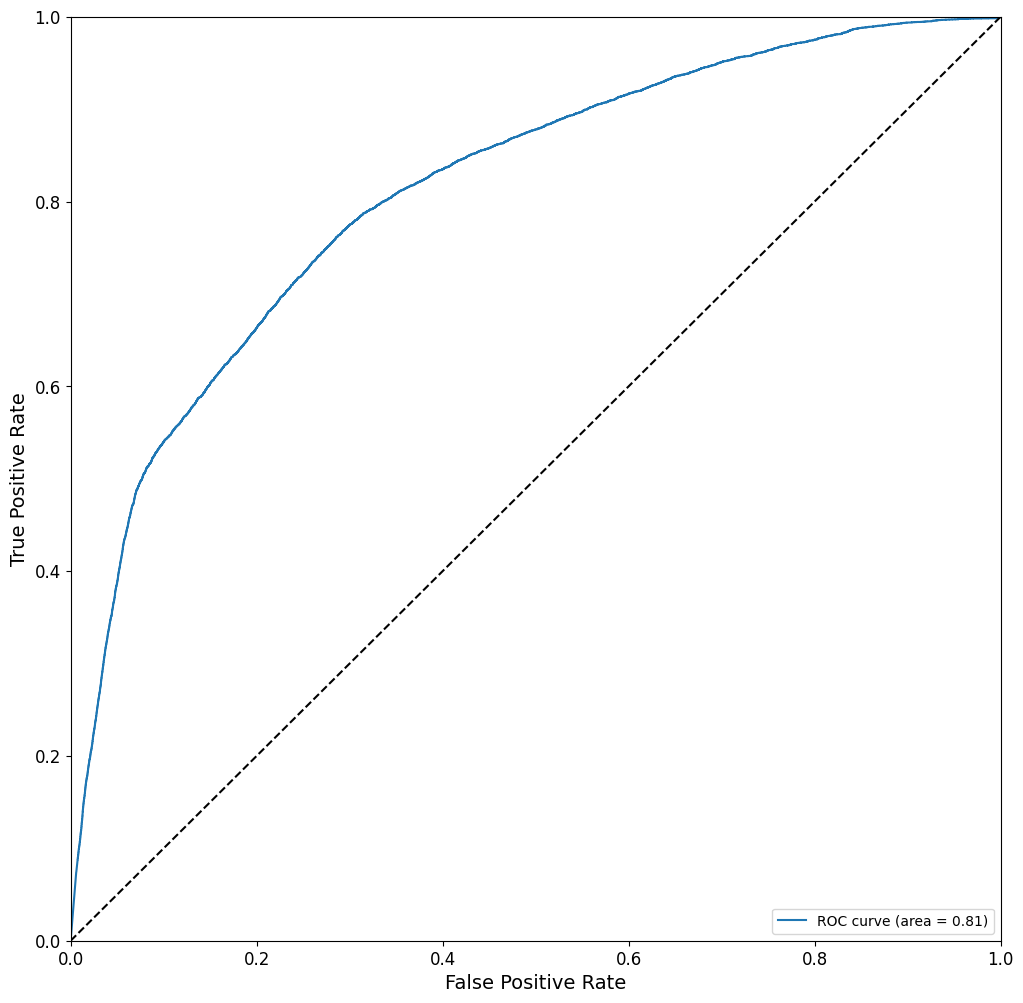

In [16]:
plt.figure(figsize = (12,12))
plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
fpr, tpr, _ = metrics.roc_curve(y_test_class, class_models['naive_bayes']['probs'])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % class_models['naive_bayes']['ROC_AUC_test'])
plt.plot([0, 1], [0, 1], 'k--')  # coin toss line
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

In [17]:
X_train_abbrev = X_train.iloc[:,[0, 1, 2, 4, 8, 9, 11, 17, 20]]
X_test_abbrev = X_test.iloc[:,[0, 1, 2, 4, 8, 9, 11, 17, 20]]
np.random.seed(rand)
sample_size = 0.1
sample_idx = np.random.choice(X_test.shape[0],\
                              math.ceil(X_test.shape[0]*sample_size), replace=False)

dimred_methods = {
        #Decomposition
        'pca':{'method': decomposition.PCA(n_components=3, random_state=rand)},  
        #Manifold Learning
        't-sne':{'method': manifold.TSNE(n_components=3, random_state=rand)},
        #Variational Autoencoders
        'vae':{'method': cvae.CompressionVAE(X_train_abbrev.values,\
                                             dim_latent=3, tb_logging=False)}, 
    }

Total amount of data:  688137
Input feature dimension:  9
Calculating normalisation factors.
Normalisation factors calculated.
Total amount of data:  76460
Creating model.
Model created.
Setting up loss.
Loss set up.
Setting up session.


2023-12-20 00:39:05.919449: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


Session set up.
Trying to restore saved checkpoints from /home/leonardo_leads/Documents/SchoolDocs/Schmidl-DS-Practice/vdsmlStarterLib/interpretableMLWpython/chapter3/temp ... No checkpoint found.
No model found to restore. Initialising new model.


In [18]:
for method_name in dimred_methods.keys():
    if method_name != 'vae':
        lowdim_data = dimred_methods[method_name]['method'].\
                        fit_transform(X_test_abbrev.values[sample_idx])
    else:
        fitted_model = dimred_methods[method_name]['method'].train(num_steps=1000)
        lowdim_data = fitted_model.embed(X_test_abbrev.values[sample_idx])
        dimred_methods[method_name]['fitted'] = fitted_model
    dimred_methods[method_name]['lowdim'] = lowdim_data

Starting queues.
Reader threads started.
step 0; epoch 0.00 - loss = 7.843, test_loss = 7.505, lr = 0.00100, (0.093 sec/step)
Storing checkpoint to /home/leonardo_leads/Documents/SchoolDocs/Schmidl-DS-Practice/vdsmlStarterLib/interpretableMLWpython/chapter3/temp ... Done.
step 50; epoch 0.00 - loss = 5.666, test_loss = 5.820, lr = 0.00100, (0.076 sec/step)
step 100; epoch 0.01 - loss = 4.798, test_loss = 4.755, lr = 0.00100, (0.077 sec/step)
step 150; epoch 0.01 - loss = 5.458, test_loss = 4.505, lr = 0.00100, (0.074 sec/step)
step 200; epoch 0.02 - loss = 4.107, test_loss = 4.366, lr = 0.00100, (0.084 sec/step)
step 250; epoch 0.02 - loss = 4.972, test_loss = 4.297, lr = 0.00100, (0.076 sec/step)
step 300; epoch 0.03 - loss = 4.147, test_loss = 4.245, lr = 0.00100, (0.076 sec/step)
step 350; epoch 0.03 - loss = 4.663, test_loss = 4.266, lr = 0.00100, (0.073 sec/step)
step 400; epoch 0.04 - loss = 4.486, test_loss = 4.302, lr = 0.00100, (0.073 sec/step)
step 450; epoch 0.04 - loss = 4.

In [19]:
y_names = {0:'Not Delayed', 1:'Delayed'}

/tmp/ipykernel_1263972/2329250337.py:1: DeprecationWarning: This method is deprecated.
  mldatasets.plot_3dim_decomposition(dimred_methods['pca']['lowdim'],\


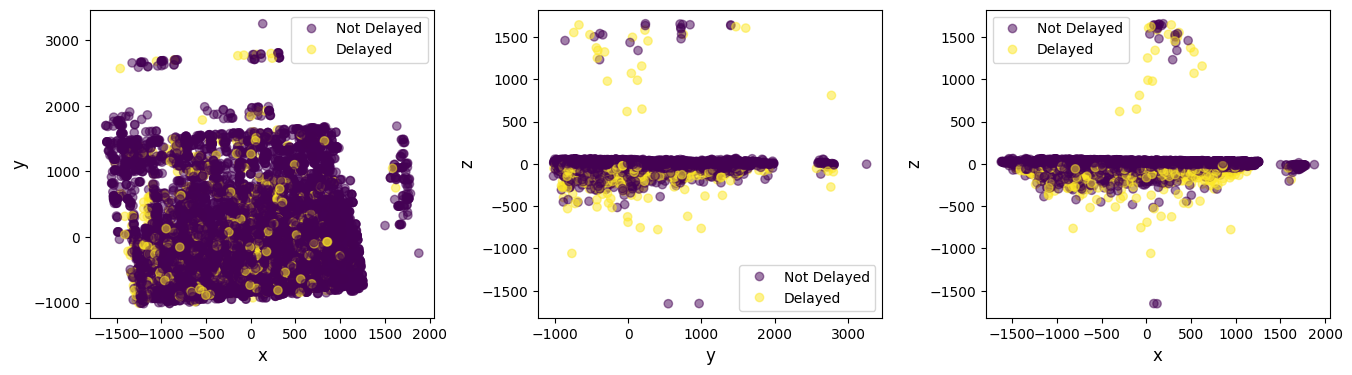

In [20]:
mldatasets.plot_3dim_decomposition(dimred_methods['pca']['lowdim'],\
                        y_test_class.values[sample_idx], y_names)

/tmp/ipykernel_1263972/2336574330.py:1: DeprecationWarning: This method is deprecated.
  mldatasets.plot_3dim_decomposition(dimred_methods['t-sne']['lowdim'],\


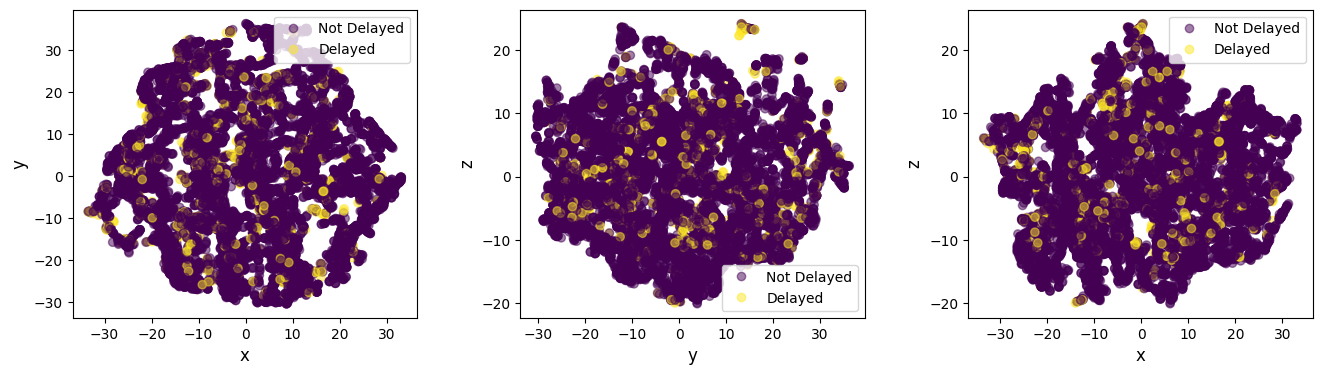

In [21]:
mldatasets.plot_3dim_decomposition(dimred_methods['t-sne']['lowdim'],\
                        y_test_class.values[sample_idx], y_names)

/tmp/ipykernel_1263972/1599456568.py:1: DeprecationWarning: This method is deprecated.
  mldatasets.plot_3dim_decomposition(dimred_methods['vae']['lowdim'],\


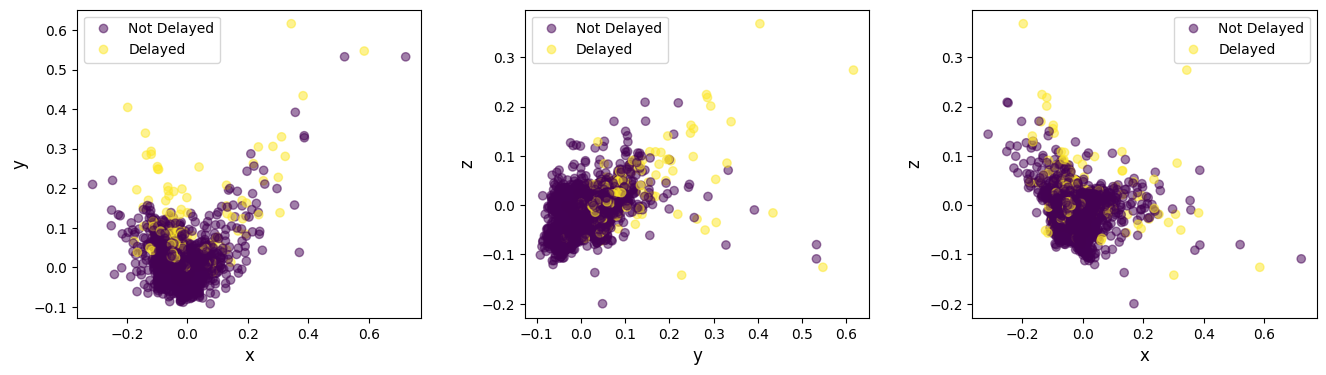

In [22]:
mldatasets.plot_3dim_decomposition(dimred_methods['vae']['lowdim'],\
                        y_test_class.values[sample_idx], y_names)

/tmp/ipykernel_1263972/2446972414.py:3: DeprecationWarning: This method is deprecated.
  error_vector, error_labels = mldatasets.encode_classification_error_vector(y_test_class_samp, y_test_pred_samp)
/tmp/ipykernel_1263972/2446972414.py:5: DeprecationWarning: This method is deprecated.
  mldatasets.plot_3dim_decomposition(dimred_methods['pca']['lowdim'],\


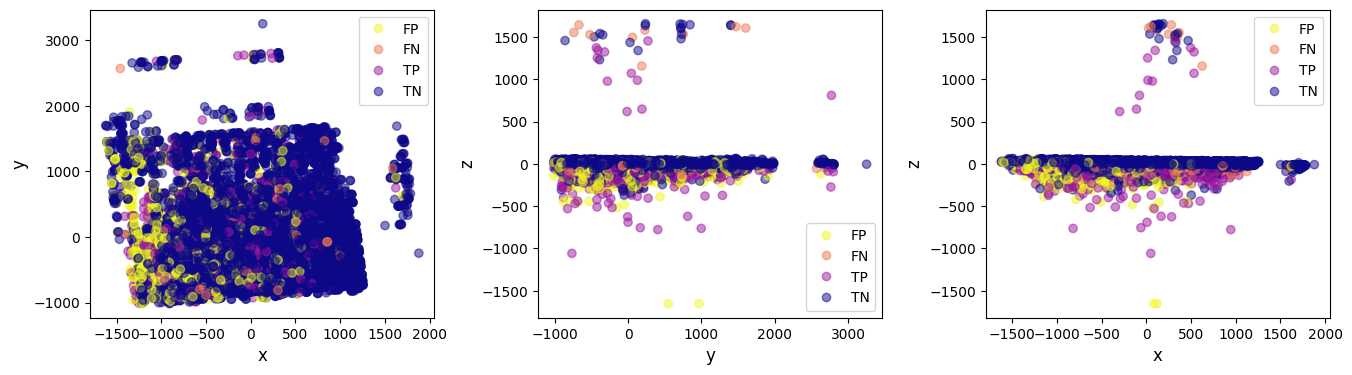

In [23]:
y_test_class_samp = y_test_class.values[sample_idx]
y_test_pred_samp = class_models['ridge']['preds'][sample_idx]
error_vector, error_labels = mldatasets.encode_classification_error_vector(y_test_class_samp, y_test_pred_samp)

mldatasets.plot_3dim_decomposition(dimred_methods['pca']['lowdim'],\
                        error_vector, error_labels)

/tmp/ipykernel_1263972/1016749249.py:1: DeprecationWarning: This method is deprecated.
  mldatasets.plot_3dim_decomposition(dimred_methods['t-sne']['lowdim'],\


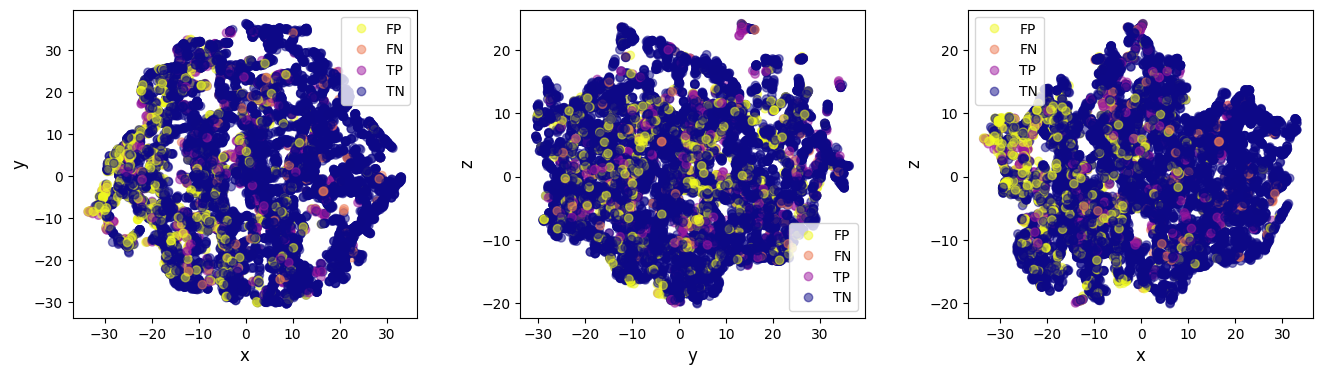

In [24]:
mldatasets.plot_3dim_decomposition(dimred_methods['t-sne']['lowdim'],\
                        error_vector, error_labels)

/tmp/ipykernel_1263972/2680525125.py:1: DeprecationWarning: This method is deprecated.
  mldatasets.plot_3dim_decomposition(dimred_methods['vae']['lowdim'],\


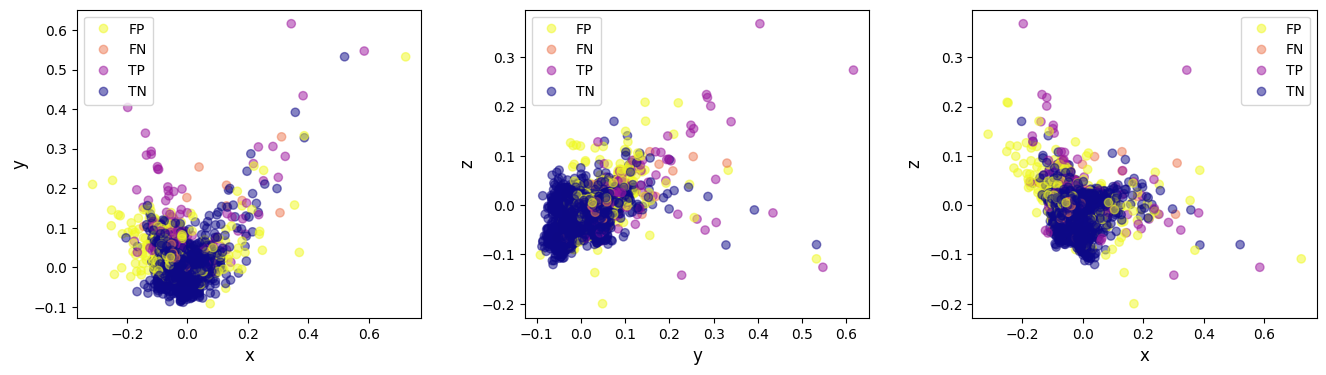

In [25]:
mldatasets.plot_3dim_decomposition(dimred_methods['vae']['lowdim'],\
                        error_vector, error_labels)


In [26]:
coefs_lm = reg_models['linear']['fitted'].coef_
intercept_lm = reg_models['linear']['fitted'].intercept_
print('coefficients:\t%s' % coefs_lm)
print('intercept:\t%s' % intercept_lm)

coefficients:	[ 4.54984539e-03 -5.25067742e-03  8.94125541e-01 -1.52961053e-02
 -4.69623002e-01  1.25277815e-01 -6.46744472e-04 -1.26240049e-02
  4.50112895e+01  6.76385421e-04 -3.69920254e-04  5.47855860e-04
  3.73866548e-01 -9.06364154e-01 -6.74052666e-01 -9.17411191e-01
 -9.29843952e-01 -3.96621856e-02 -1.79666480e-02 -1.02912927e+00
 -3.94934854e-01]
intercept:	-37.8617793275263


In [27]:
print('ŷ = %0.2f + %0.4fX₁ + %0.4fX₂ + %0.3fX₃ + ...' %\
      (intercept_lm, coefs_lm[0], coefs_lm[1], coefs_lm[2]))

ŷ = -37.86 + 0.0045X₁ + -0.0053X₂ + 0.894X₃ + ...


In [28]:
coef_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),\
                        'coef': coefs_lm})
print(coef_df)

                feature       coef
0          CRS_DEP_TIME   0.004550
1              DEP_TIME  -0.005251
2             DEP_DELAY   0.894126
3              DEP_AFPH  -0.015296
4              DEP_RFPH  -0.469623
5              TAXI_OUT   0.125278
6            WHEELS_OFF  -0.000647
7      CRS_ELAPSED_TIME  -0.012624
8      PCT_ELAPSED_TIME  45.011289
9              DISTANCE   0.000676
10         CRS_ARR_TIME  -0.000370
11             ARR_AFPH   0.000548
12             ARR_RFPH   0.373867
13        WEATHER_DELAY  -0.906364
14            NAS_DELAY  -0.674053
15       SECURITY_DELAY  -0.917411
16  LATE_AIRCRAFT_DELAY  -0.929844
17            DEP_MONTH  -0.039662
18              DEP_DOW  -0.017967
19           ORIGIN_HUB  -1.029129
20             DEST_HUB  -0.394935


In [29]:
linreg_mdl = sm.OLS(y_train_reg, sm.add_constant(X_train))
linreg_mdl = linreg_mdl.fit()
linreg_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          CARRIER_DELAY   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 4.251e+05
Date:                Wed, 20 Dec 2023   Prob (F-statistic):               0.00
Time:                        00:43:11   Log-Likelihood:            -2.6574e+06
No. Observations:              764597   AIC:                         5.315e+06
Df Residuals:                  764575   BIC:                         5.315e+06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -37.8618      0.125   -301.763      0.000     -38.108     -37.616
CRS_DEP_TIME            0.0045   7.24e-05     62.872      0.000       0.004       0.005
DEP_TIME               -0.0053   9.19e-05    -57.116      0.000      -0.005      -0.005
DEP_DELAY               0.8941      0.000   2951.056      0.000       0.894       0.895
DEP_AFPH               -0.0153      0.000    -47.725      0.000      -0.016      -0.015
DEP_RFPH               -0.4696      0.017    -27.353      0.000      -0.503      -0.436
TAXI_OUT                0.1253      0.001    104.120      0.000       0.123       0.128
WHEELS_OFF             -0.0006    6.7e-05     -9.646      0.000      -0.001      -0.001
CRS_ELAPSED_TIME       -0.0126      0.001    -19.132      0.000      -0.014      -0.011
PCT_ELAPSED_TIME       45.0113      0.117    384.073      0.000      44.782      45.241
DISTANCE                0.0007   8.02e-05      8.429      0.000       0.001       0.001
CRS_ARR_TIME           -0.0004   2.18e-05    -16.939      0.000      -0.000      -0.000
ARR_AFPH                0.0005      0.000      1.651      0.099      -0.000       0.001
ARR_RFPH                0.3739      0.013     28.386      0.000       0.348       0.400
WEATHER_DELAY          -0.9064      0.001   -995.366      0.000      -0.908      -0.905
NAS_DELAY              -0.6741      0.001   -829.129      0.000      -0.676      -0.672
SECURITY_DELAY         -0.9174      0.005   -167.857      0.000      -0.928      -0.907
LATE_AIRCRAFT_DELAY    -0.9298      0.001  -1827.018      0.000      -0.931      -0.929
DEP_MONTH              -0.0397      0.003    -15.019      0.000      -0.045      -0.034
DEP_DOW                -0.0180      0.004     -4.005      0.000      -0.027      -0.009
ORIGIN_HUB             -1.0291      0.027    -38.589      0.000      -1.081      -0.977
DEST_HUB               -0.3949      0.026    -15.041      0.000      -0.446      -0.343
==============================================================================
Omnibus:                   211121.387   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         24359701.834
Skew:                           0.098   Prob(JB):                         0.00
Kurtosis:                      30.651   Cond. No.                     5.69e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
summary_df = linreg_mdl.summary2().tables[1]
summary_df = summary_df.drop(['const']).reset_index().rename(columns={'index':'feature'})
summary_df['t_abs'] = abs(summary_df['t'])
summary_df.sort_values(by='t_abs', ascending=False).style.\
    background_gradient(cmap='plasma_r', low=0, high=0.1, subset=['P>|t|']).\
    background_gradient(cmap='plasma_r', low=0, high=0.1, subset=['t_abs'])

,feature,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],t_abs
2,DEP_DELAY,0.894126,0.000303,2951.055978,0.000000,0.893532,0.894719,2951.055978
16,LATE_AIRCRAFT_DELAY,-0.929844,0.000509,-1827.018082,0.000000,-0.930841,-0.928846,1827.018082
13,WEATHER_DELAY,-0.906364,0.000911,-995.366423,0.000000,-0.908149,-0.904579,995.366423
14,NAS_DELAY,-0.674053,0.000813,-829.128657,0.000000,-0.675646,-0.672459,829.128657
8,PCT_ELAPSED_TIME,45.011289,0.117195,384.072566,0.000000,44.781592,45.240987,384.072566
15,SECURITY_DELAY,-0.917411,0.005465,-167.857085,0.000000,-0.928123,-0.906699,167.857085
5,TAXI_OUT,0.125278,0.001203,104.119579,0.000000,0.122920,0.127636,104.119579
0,CRS_DEP_TIME,0.004550,0.000072,62.871693,0.000000,0.004408,0.004692,62.871693
1,DEP_TIME,-0.005251,0.000092,-57.115895,0.000000,-0.005431,-0.005070,57.115895
3,DEP_AFPH,-0.015296,0.000321,-47.724506,0.000000,-0.015924,-0.014668,47.724506


In [31]:
coefs_ridge = reg_models['ridge']['fitted'].coef_
coef_ridge_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),\
                        'coef_linear': coefs_lm,\
                        'coef_ridge': coefs_ridge})
coef_ridge_df.style.\
    background_gradient(cmap='viridis_r', low=0.3, high=0.2, axis=1)

,feature,coef_linear,coef_ridge
0,CRS_DEP_TIME,0.004550,0.004388
1,DEP_TIME,-0.005251,-0.005033
2,DEP_DELAY,0.894126,0.892912
3,DEP_AFPH,-0.015296,-0.015074
4,DEP_RFPH,-0.469623,-0.469627
5,TAXI_OUT,0.125278,0.125178
6,WHEELS_OFF,-0.000647,-0.000037
7,CRS_ELAPSED_TIME,-0.012624,-0.012630
8,PCT_ELAPSED_TIME,45.011289,45.011278
9,DISTANCE,0.000676,0.000726


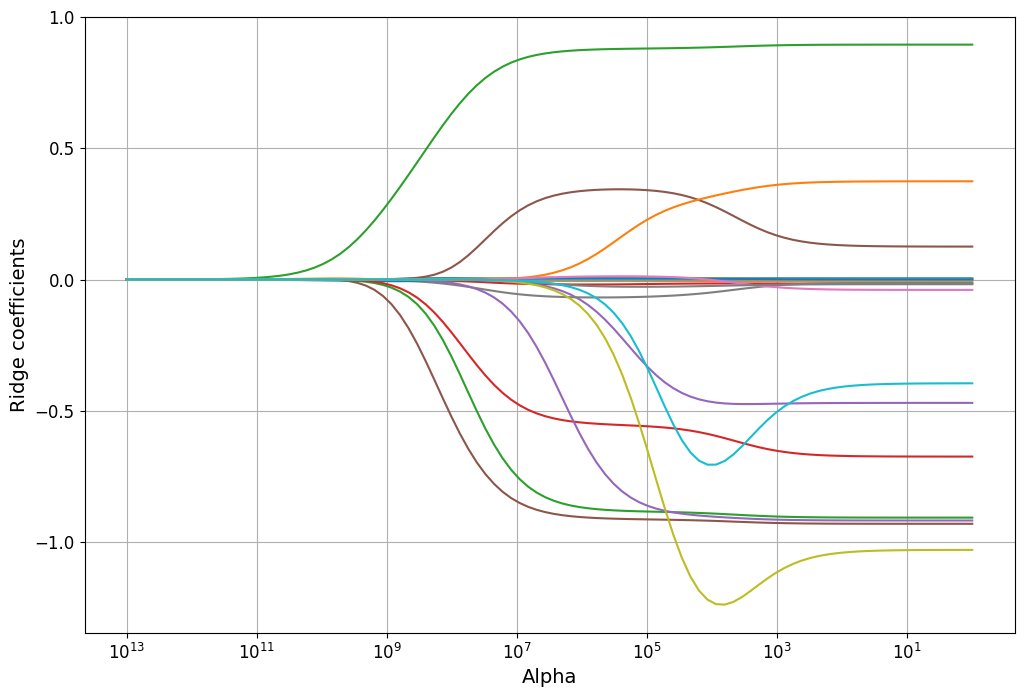

In [32]:
num_alphas = 100
alphas = np.logspace(0, 13, num_alphas)
alphas_coefs = []
for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha).fit(X_train, y_train_reg)
    alphas_coefs.append(np.concatenate((ridge.coef_[:8],ridge.coef_[9:])))

plt.figure(figsize = (12,8))
plt.gca().invert_xaxis()
plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.plot(alphas, alphas_coefs)
plt.xscale("log")
plt.xlabel('Alpha', fontsize = 14)
plt.ylabel('Ridge coefficients', fontsize = 14)
plt.grid()
plt.show()

In [35]:
print(reg_models['linear_poly']['fitted'].get_params()['linearregression'].coef_.shape[0])

print(reg_models['linear_interact']['fitted'].get_params()['linearregression'].coef_.shape[0])

coefs_log = class_models['logistic']['fitted'].coef_
intercept_log = class_models['logistic']['fitted'].intercept_
print('coefficients:\t%s' % coefs_log)
print('intercept:\t%s' % intercept_log)

stdv = np.std(X_train, 0)
abs(coefs_log.reshape(21,) * stdv).sort_values(ascending=False)

253
232
coefficients:	[[-0.0010664  -0.00025256  0.15980426  0.00205643 -0.00211894 -0.0047671
   0.00049626 -0.05126985 -0.00174075  0.00554614 -0.00024115 -0.00702844
  -0.00270477 -0.15062337 -0.11886929 -0.00584508 -0.16368245 -0.01291451
  -0.00524169  0.00047131 -0.00203634]]
intercept:	[-0.00227013]


DEP_DELAY              7.073640
CRS_ELAPSED_TIME       4.069586
LATE_AIRCRAFT_DELAY    4.044867
DISTANCE               3.601811
NAS_DELAY              1.638024
WEATHER_DELAY          1.573975
CRS_DEP_TIME           0.534701
WHEELS_OFF             0.256364
ARR_AFPH               0.248548
DEP_TIME               0.130043
CRS_ARR_TIME           0.127362
DEP_AFPH               0.072911
TAXI_OUT               0.047047
DEP_MONTH              0.044073
DEP_DOW                0.010475
SECURITY_DELAY         0.009581
ARR_RFPH               0.001951
DEP_RFPH               0.001197
DEST_HUB               0.000991
ORIGIN_HUB             0.000229
PCT_ELAPSED_TIME       0.000183
dtype: float64

/tmp/ipykernel_1263972/232009503.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


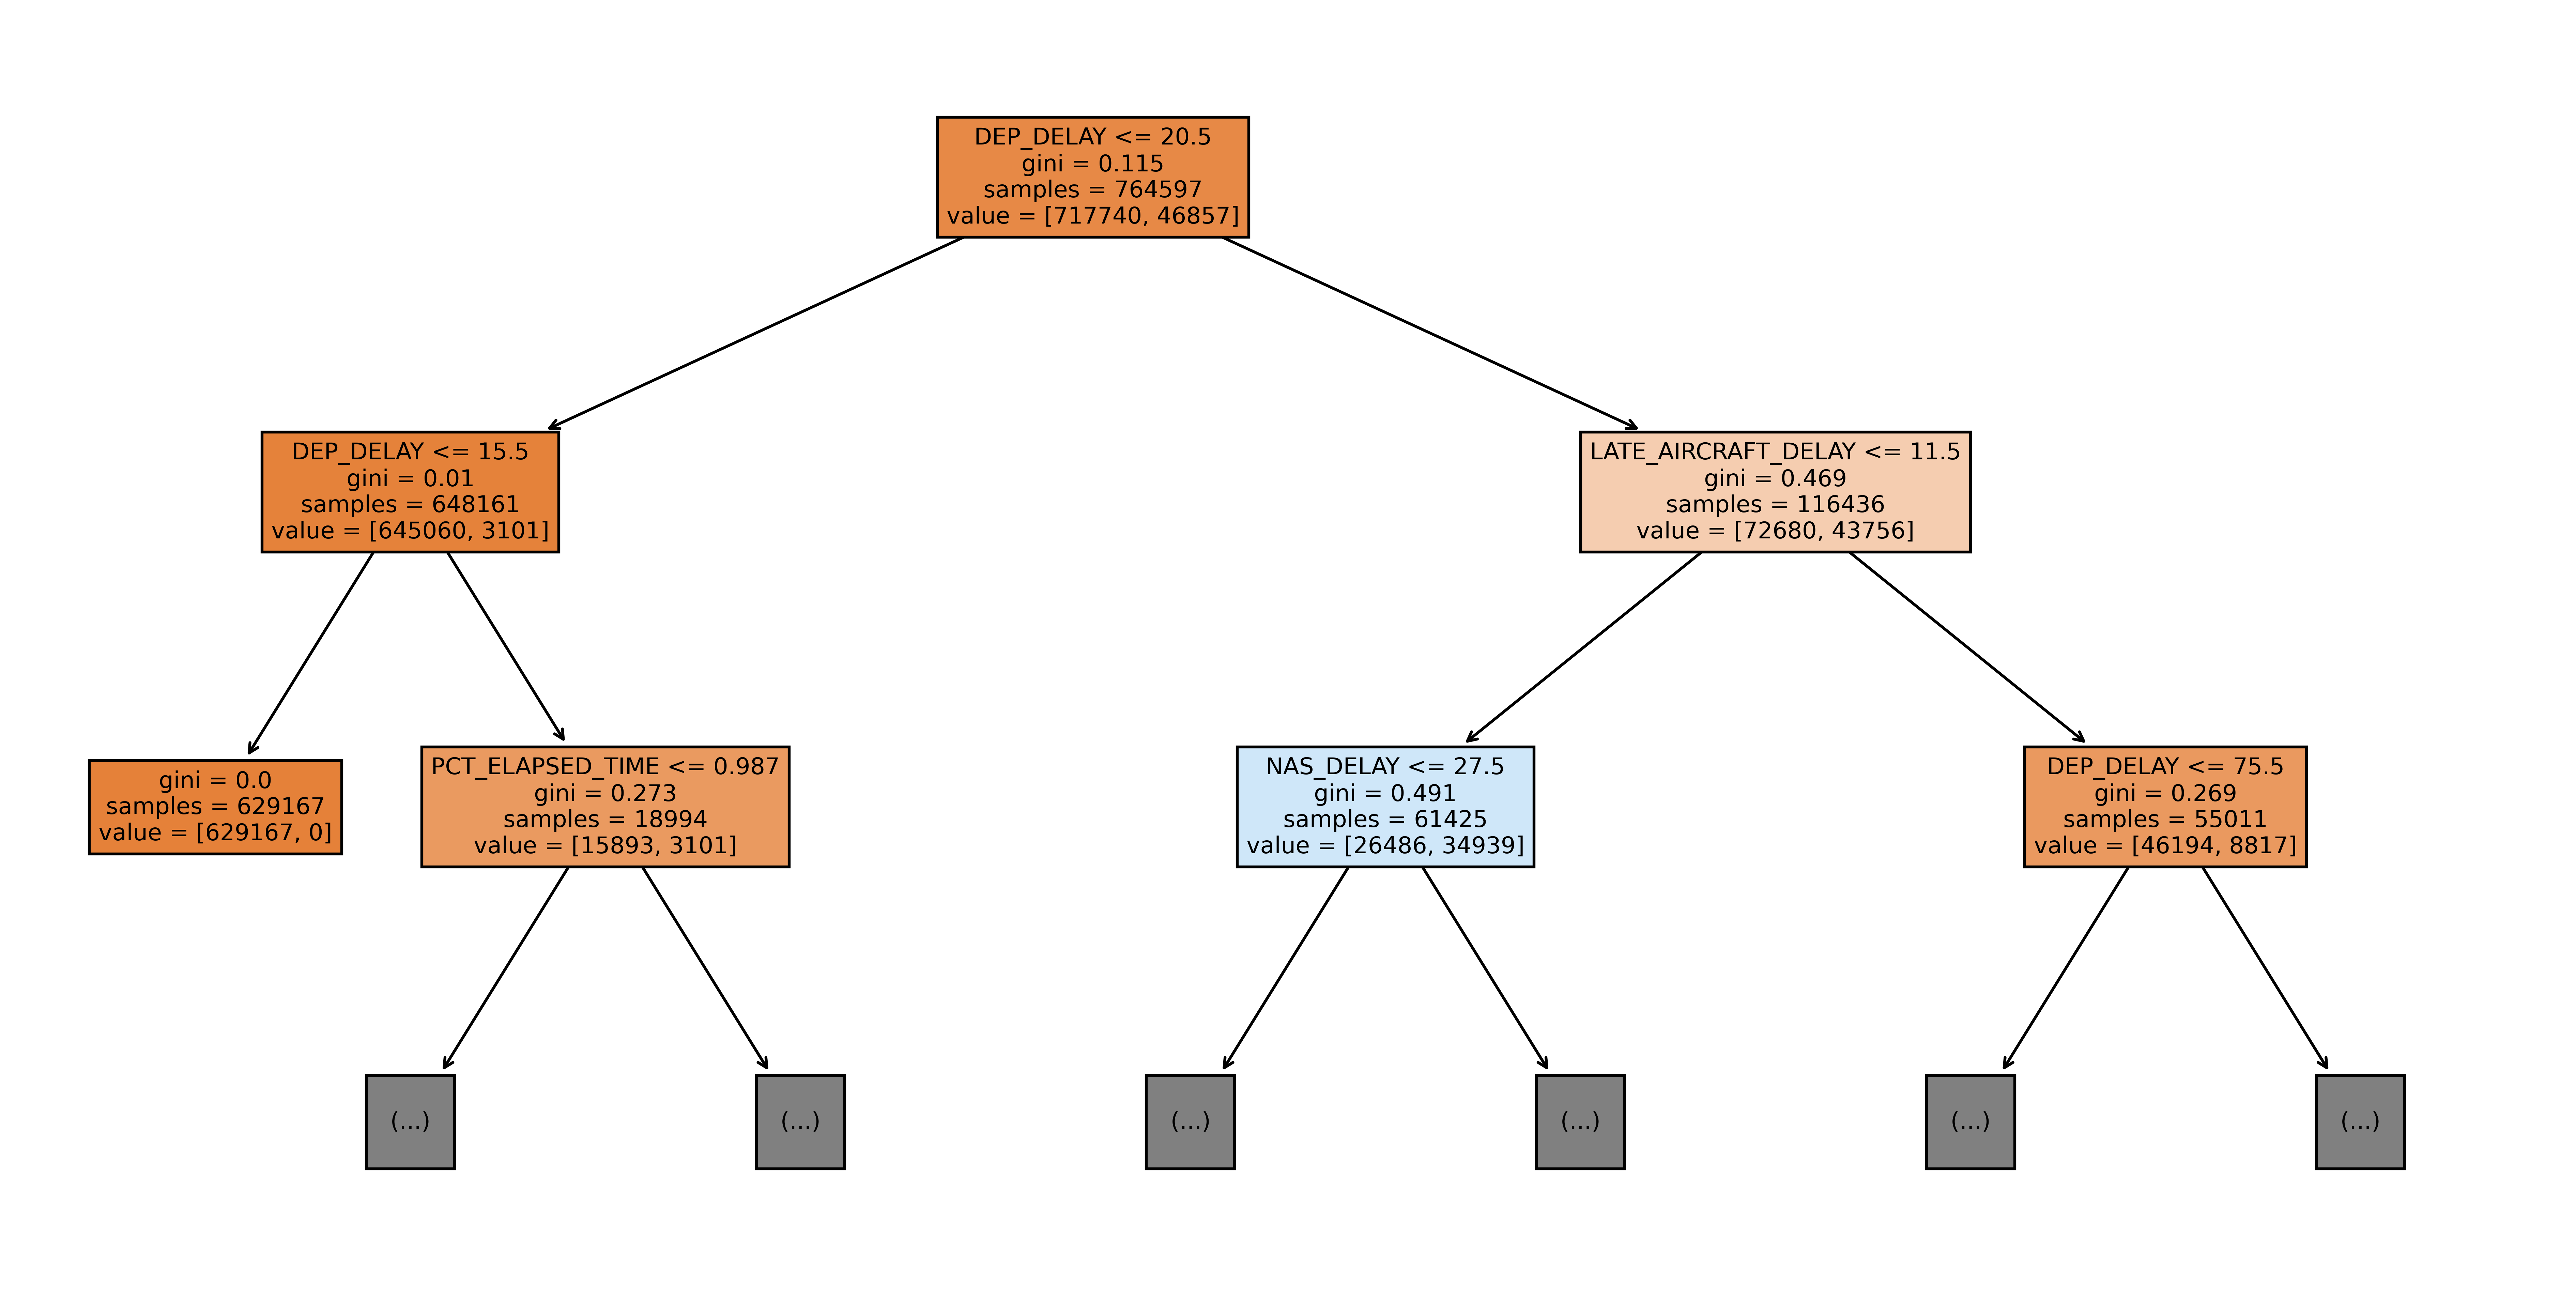

In [36]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16,8), dpi=600)
tree.plot_tree(class_models['decision_tree']['fitted'],\
               feature_names=X_train.columns.values.tolist(), filled = True, max_depth=2)
fig.show()

In [37]:
text_tree = tree.export_text(class_models['decision_tree']['fitted'],\
               feature_names=X_train.columns.values.tolist())
print(text_tree)

|--- DEP_DELAY <= 20.50
|   |--- DEP_DELAY <= 15.50
|   |   |--- class: 0
|   |--- DEP_DELAY >  15.50
|   |   |--- PCT_ELAPSED_TIME <= 0.99
|   |   |   |--- PCT_ELAPSED_TIME <= 0.98
|   |   |   |   |--- PCT_ELAPSED_TIME <= 0.96
|   |   |   |   |   |--- CRS_ELAPSED_TIME <= 65.50
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME <= 0.94
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME >  0.94
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- CRS_ELAPSED_TIME >  65.50
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME <= 0.95
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME >  0.95
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- PCT_ELAPSED_TIME >  0.96
|   |   |   |   |   |--- CRS_ELAPSED_TIME <= 140.50
|   |   |   |   |   |   |--- DEP_DELAY <= 18.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- DEP_DELAY >  18.50
|   |   |   |   |   |   |   |--- class: 0
|   |   

In [38]:
dt_imp_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),\
                        'importance': class_models['decision_tree']['fitted'].feature_importances_}).\
            sort_values(by='importance', ascending=False)
dt_imp_df

,feature,importance
2,DEP_DELAY,0.527482
16,LATE_AIRCRAFT_DELAY,0.199153
8,PCT_ELAPSED_TIME,0.105381
13,WEATHER_DELAY,0.101649
14,NAS_DELAY,0.062732
15,SECURITY_DELAY,0.001998
9,DISTANCE,0.001019
7,CRS_ELAPSED_TIME,0.000281
5,TAXI_OUT,0.000239
6,WHEELS_OFF,0.000035


In [39]:
rulefit_df = reg_models['rulefit']['fitted'].get_rules()
rulefit_df = rulefit_df[rulefit_df.coef != 0].sort_values(by="importance", ascending=False)
rulefit_df

,rule,type,coef,support,importance
55,WEATHER_DELAY <= 166.0 & DEP_DELAY > 344.0 & L...,rule,222.068473,0.001684,9.103907
126,LATE_AIRCRAFT_DELAY <= 333.5 & DEP_DELAY > 477.5,rule,177.651421,0.001122,5.948206
16,LATE_AIRCRAFT_DELAY,linear,-0.386194,1.000000,4.525085
2,DEP_DELAY,linear,0.163679,1.000000,4.282262
101,DEP_DELAY <= 1206.0,rule,-292.111050,0.999813,3.994780
...,...,...,...,...,...
137,DEP_DELAY <= 48.5 & DEP_DELAY <= 534.5,rule,-0.082095,0.921811,0.022040
18,DEP_DOW,linear,0.009910,1.000000,0.019805
69,LATE_AIRCRAFT_DELAY <= 8.5 & DEP_DELAY > 47.5 ...,rule,0.078008,0.033857,0.014109
123,DEP_DELAY > 1206.0,rule,0.201436,0.000187,0.002755


In [40]:
print(X_test.loc[721043,:])

CRS_DEP_TIME            655.000000
DEP_TIME               1055.000000
DEP_DELAY               240.000000
DEP_AFPH                 90.800000
DEP_RFPH                  0.890196
TAXI_OUT                 35.000000
WHEELS_OFF             1130.000000
CRS_ELAPSED_TIME        259.000000
PCT_ELAPSED_TIME          1.084942
DISTANCE               1660.000000
CRS_ARR_TIME            914.000000
ARR_AFPH                 40.434783
ARR_RFPH                  1.064073
WEATHER_DELAY             0.000000
NAS_DELAY                22.000000
SECURITY_DELAY            0.000000
LATE_AIRCRAFT_DELAY     221.000000
DEP_MONTH                10.000000
DEP_DOW                   4.000000
ORIGIN_HUB                1.000000
DEST_HUB                  0.000000
Name: 721043, dtype: float64


In [41]:
print(y_test_class[721043])


print(y_test_class[721043])

print(class_models['knn']['preds'][X_test.index.get_loc(721043)])

print(class_models['knn']['fitted'].kneighbors(X_test.loc[721043,:].values.reshape(1,21), 7))

1
1
0
(array([[143.3160128 , 173.90740076, 192.66705727, 211.57109221,
        243.57211853, 259.61593993, 259.77507391]]), array([[105172, 571912,  73409,  89450,  77474, 705972, 706911]]))


In [43]:
print(y_train_class.iloc[[105172, 571912,  73409,  89450,  77474, 705972, 706911]])

print(class_models['knn']['fitted'].effective_metric_)

print(class_models['naive_bayes']['fitted'].class_prior_)

print(class_models['naive_bayes']['fitted'].var_)

3813      0
229062    1
283316    0
385831    0
581905    1
726784    1
179364    0
Name: CARRIER_DELAY, dtype: int64
euclidean
[0.93871674 0.06128326]
[[2.50123026e+05 2.61324730e+05 9.21572605e+02 1.26123968e+03
  2.08339528e-01 9.58074414e+01 2.62606651e+05 6.30102550e+03
  1.13475535e-02 4.22470414e+05 2.75433641e+05 1.25314386e+03
  3.48655340e-01 1.11234714e+02 1.91877186e+02 2.80302201e+00
  5.06561612e+02 1.17346654e+01 3.99122491e+00 2.39015406e-01
  2.34996222e-01]
 [2.60629652e+05 2.96009867e+05 1.19307931e+04 1.14839167e+03
  1.99929921e+00 1.20404927e+02 3.08568277e+05 6.29066219e+03
  1.38936741e-02 4.10198938e+05 3.28574000e+05 1.09023147e+03
  3.08997044e+00 7.79140423e+01 1.56184090e+02 9.12112286e-01
  2.11279954e+03 1.02712368e+01 4.02943162e+00 1.77750796e-01
  2.50208354e-01]]


In [44]:
print(class_models['naive_bayes']['fitted'].theta_)

[[1.30740577e+03 1.31006271e+03 5.14196506e+00 5.45864877e+01
  1.09377996e+00 1.87120810e+01 1.33552258e+03 1.70734929e+02
  9.71131781e-01 1.01824369e+03 1.48438931e+03 5.39873058e+01
  1.09644787e+00 7.39971299e-01 2.85434558e+00 2.41814585e-02
  4.14674395e+00 6.55045281e+00 2.95035528e+00 6.06800513e-01
  6.24199571e-01]
 [1.41305545e+03 1.48087887e+03 8.45867640e+01 6.14731036e+01
  1.25429654e+00 1.99378321e+01 1.49409412e+03 1.72229998e+02
  9.83974416e-01 1.04363666e+03 1.54821862e+03 4.26486417e+01
  1.36373798e+00 4.50733082e-01 4.71991378e+00 2.11281132e-02
  1.40744819e+01 6.73367907e+00 3.04251232e+00 7.69575517e-01
  4.85391724e-01]]


In [45]:
#Make new abbreviated versions of datasets
feature_samp = ['DEP_DELAY', 'LATE_AIRCRAFT_DELAY', 'PCT_ELAPSED_TIME', 'WEATHER_DELAY',\
                'NAS_DELAY', 'SECURITY_DELAY', 'DISTANCE', 'CRS_ELAPSED_TIME']
X_train_abbrev2 = X_train[feature_samp]
X_test_abbrev2 = X_test[feature_samp]
#For sampling among observations
np.random.seed(rand)
sample2_size = 0.1
sample2_idx = np.random.choice(X_train.shape[0], math.ceil(X_train.shape[0]*sample2_size), replace=False)

ebm_mdl = ExplainableBoostingClassifier()
ebm_mdl.fit(X_train_abbrev2.iloc[sample2_idx], y_train_class.iloc[sample2_idx])

ExplainableBoostingClassifier()

In [46]:
show(ebm_mdl.explain_global())

ebm_lcl = ebm_mdl.explain_local(X_test_abbrev2.iloc[76:77],\
                                y_test_class[76:77], name='EBM')
show(ebm_lcl)


ebm_perf = ROC(ebm_mdl.predict_proba).\
                            explain_perf(X_test_abbrev2.iloc[sample_idx],\
                                         y_test_class.iloc[sample_idx], name='EBM')
show(ebm_perf)

<!-- http://127.0.0.1:7001/140237197830288/ -->

<!-- http://127.0.0.1:7001/140242583662288/ -->

<!-- http://127.0.0.1:7001/140242583719952/ -->

In [47]:
sr_mdl = SkopeRules(n_estimators=200, precision_min=0.2, recall_min=0.01,\
                    n_jobs=-1, random_state=rand, max_depth=7,\
                    feature_names=X_train_abbrev2.columns)
sr_mdl.fit(X_train_abbrev2.iloc[sample2_idx], y_train_class.iloc[sample2_idx])

sr_y_test_prob = sr_mdl.score_top_rules(X_test_abbrev2.iloc[sample_idx])
sr_y_test_pred = np.where(sr_y_test_prob > 0.5, 1, 0)

/home/leonardo_leads/miniconda3/envs/interml/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.

/home/leonardo_leads/miniconda3/envs/interml/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.



In [48]:
print(len(sr_mdl.rules_))


print(sr_mdl.rules_[0:5])

print('actual: %s, predicted: %s' % (y_test_class.iloc[76], sr_y_test_pred[76]))

print(sr_mdl.decision_function(X_test_abbrev2.iloc[76:77]))

print('accuracy: %.3g, recall: %.3g, roc auc: %.3g, f1: %.3g, mcc: %.3g' %\
      (metrics.accuracy_score(y_test_class.iloc[sample_idx], sr_y_test_pred),\
       metrics.recall_score(y_test_class.iloc[sample_idx], sr_y_test_pred),\
       metrics.roc_auc_score(y_test_class.iloc[sample_idx], sr_y_test_prob),\
       metrics.f1_score(y_test_class.iloc[sample_idx], sr_y_test_pred),\
       metrics.matthews_corrcoef(y_test_class.iloc[sample_idx], sr_y_test_pred)))

1493
[('DEP_DELAY > 39.5 and LATE_AIRCRAFT_DELAY <= 12.5 and WEATHER_DELAY <= 12.0 and NAS_DELAY <= 29.5 and SECURITY_DELAY <= 8.5', (0.9585547290116897, 0.4800425758382118, 2)), ('DEP_DELAY > 39.5 and LATE_AIRCRAFT_DELAY <= 11.5 and WEATHER_DELAY <= 12.5 and NAS_DELAY <= 27.5 and SECURITY_DELAY <= 8.5', (0.9608998393144081, 0.47586206896551725, 2)), ('DEP_DELAY > 39.5 and LATE_AIRCRAFT_DELAY <= 12.5 and WEATHER_DELAY <= 12.0 and NAS_DELAY <= 27.5 and SECURITY_DELAY <= 16.5', (0.9579037047855509, 0.47316836019772934, 4)), ('DEP_DELAY > 39.5 and LATE_AIRCRAFT_DELAY <= 11.5 and WEATHER_DELAY <= 12.0 and NAS_DELAY <= 27.5 and SECURITY_DELAY <= 16.5', (0.9602813485868389, 0.4706939497340879, 32)), ('DEP_DELAY > 39.5 and LATE_AIRCRAFT_DELAY <= 11.5 and WEATHER_DELAY <= 12.5 and NAS_DELAY <= 29.5 and SECURITY_DELAY <= 16.5', (0.9568034557235421, 0.4715274081958489, 2))]
actual: 1, predicted: 0
[18.46755085]
accuracy: 0.96, recall: 0.979, roc auc: 0.983, f1: 0.745, mcc: 0.75
